In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import pandas as pd

c:\Users\caste\anaconda3\envs\pytochCuda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

#Separar el dataset en train y test (80% train, 20% test) Finaltrain.csv

df = pd.read_csv('data/Finaltrain.csv')
df = df.sample(frac=1).reset_index(drop=True)
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]

train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [3]:
train_data.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_length,word_count,number_count,punctuation_count,stopword_count
0,93ef932e0c91,3b9047,The egyptain government ladder was set up fair...,0.684545,-0.494455,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,848,150,0,4,88
1,a4fb4b0050e1,814d6b,The experiment was ended because the nazis end...,-0.831253,0.550583,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave ex...,212,34,0,3,10
2,14af7a065044,ebad26,"Factories would take spoiled meat and ""can it ...",1.204312,-0.090227,Summarize the various ways the factory would u...,Excerpt from The Jungle,With one member trimming beef ...,599,116,0,10,54
3,9b5c29d6fd7a,3b9047,Ancient Egyptian class systems are formed like...,-0.093814,0.503833,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structure...,241,43,0,6,17
4,dc3e48eb2739,814d6b,The student were able to recruit other studen...,-0.986247,0.430210,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave ex...,163,32,1,3,17


In [4]:
train_data['text'].tolist()

["The egyptain government ladder was set up fair but not fair at the same time because they had the gods at the top of there ladder than they had the pharaohs an they had the people who was under the pharaohs which was the powerful nobels an priests an than they had the farmers an slaves the farmers helped the government because they need food an the farmers was giving them money the slaves helped the government buy building stufff for them if they didn't have slaves they wouldn't how as many buildings as they had the high nobels an priest helped he government because the slaves worshiped them without them there wouldn't be no food or buildings the pharoahs helped the government because they had powers that could control people but they couldn't do everything the gods was gods they helped the governmen by accending othere people into gods",
 'The experiment was ended because the nazis ended after the war. The third wave effected discipline and behavior. It sharpened skills and base kno

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer.batch_encode_plus(
    train_data['text'].tolist(),
    truncation=True,
    padding=True
)

test_encodings = tokenizer.batch_encode_plus(
    test_data['text'].tolist(),
    truncation=True,
    padding=True
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_data['content'].tolist()),
    torch.tensor(train_data['wording'].tolist())
)

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask'])
)


In [6]:
class BERTModel(nn.Module):
  def __init__(self):
      super(BERTModel, self).__init__()
      self.bert = BertModel.from_pretrained('bert-base-uncased')

      self.dropout = nn.Dropout(0.1)
      self.linear1 = nn.Linear(768, 256)
      self.linear2 = nn.Linear(256, 2)

  def forward(self, input_ids, attention_mask):
      outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output
      pooled_output = self.dropout(pooled_output)
      output = self.linear1(pooled_output)
      output = nn.ReLU()(output)
      output = self.linear2(output)
      return output

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = BERTModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

cuda


In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [9]:
# Splitting training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Creating validation loader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

In [10]:
# Training loop
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

model.train()
for epoch in range(5):
    running_loss = 0.0
    running_mae = 0.0
    
    for step, (input_ids, attention_mask, content, wording) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        content = content.to(device)
        wording = wording.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = (criterion(outputs[:, 0], content) + criterion(outputs[:, 1], wording))
        loss.backward()
        optimizer.step()

        mae = torch.mean(torch.abs(outputs[:, 0] - content) + torch.abs(outputs[:, 1] - wording)).item()

        running_loss += loss.item()
        running_mae += mae

    epoch_loss = running_loss / len(train_loader)
    epoch_mae = running_mae / len(train_loader)
    history['loss'].append(epoch_loss)
    history['mae'].append(epoch_mae)

    print(f"Epoch {epoch+1} Loss: {epoch_loss}, MAE: {epoch_mae}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_mae = 0.0
        for val_step, (input_ids, attention_mask, content, wording) in enumerate(val_loader):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            content = content.to(device)
            wording = wording.to(device)

            val_outputs = model(input_ids, attention_mask)
            val_loss += (criterion(val_outputs[:, 0], content) + criterion(val_outputs[:, 1], wording))
            val_mae += torch.mean(torch.abs(val_outputs[:, 0] - content) + torch.abs(val_outputs[:, 1] - wording)).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_mae'].append(avg_val_mae)

        print(f"Validation Loss: {avg_val_loss}, Validation MAE: {avg_val_mae}")
    model.train()

c:\Users\caste\anaconda3\envs\pytochCuda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1 Loss: 0.9602770916598753, MAE: 1.0526980684660272
Validation Loss: 0.5903065800666809, Validation MAE: 0.8301807559198804
Epoch 2 Loss: 0.5615647114335992, MAE: 0.8086596085666614
Validation Loss: 0.4385486841201782, Validation MAE: 0.7109748708705107
Epoch 3 Loss: 0.4347195595834913, MAE: 0.7132029686963658
Validation Loss: 0.32963910698890686, Validation MAE: 0.6208823269440068
Epoch 4 Loss: 0.35580420132965096, MAE: 0.652964898719761
Validation Loss: 0.24227145314216614, Validation MAE: 0.5456733542184035
Epoch 5 Loss: 0.2908419343671427, MAE: 0.5922021207537159
Validation Loss: 0.20336118340492249, Validation MAE: 0.49400264728400445
Epoch 6 Loss: 0.24935556246709692, MAE: 0.5514191297767554
Validation Loss: 0.2654012441635132, Validation MAE: 0.5732915186219745
Epoch 7 Loss: 0.21065350617787965, MAE: 0.5057093323439277
Validation Loss: 0.13820084929466248, Validation MAE: 0.4109258039130105
Epoch 8 Loss: 0.1830185418922589, MAE: 0.47533197231943564
Validation Loss: 0.12826

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

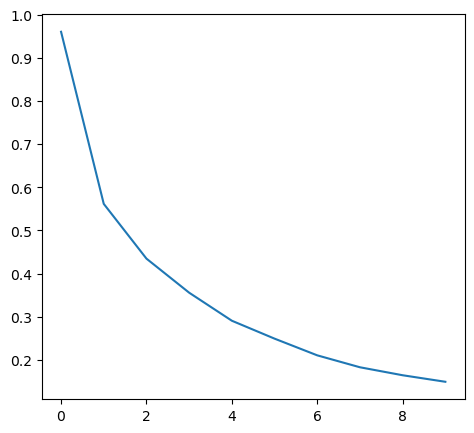

In [11]:
# import matplotlib.pyplot as plt
# # Plotting the results
# plt.figure(figsize=(12, 5))
# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(history['loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

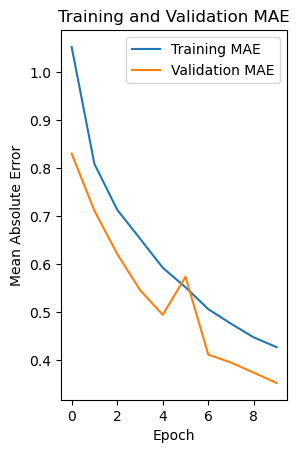

In [12]:
# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history['mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

In [13]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
model.eval()
predictions = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.cpu().numpy())

In [15]:
submission_df = pd.DataFrame({
    'student_id': test_data['student_id'],
    'content': [pred[0] for pred in predictions],
    'wording': [pred[1] for pred in predictions]
})

submission_df.to_csv('submission.csv', index=False)

In [16]:
submission_df

,student_id,content,wording
5732,1e0a1fe23c2c,-0.724456,-0.474162
5733,580799688bfb,0.872110,0.412599
5734,ebe98401396b,1.742677,1.203868
5735,d31efd235dbb,-1.460548,-1.510787
5736,b1a801f9c2f4,-0.936427,-1.612795
...,...,...,...
7160,c83a3eae167f,-0.319540,-1.015736
7161,7c1e4043f538,0.287116,0.251731
7162,b0e06a58b72b,-1.297924,-1.292348
7163,ba67a5110fd5,-0.828636,-0.218315


In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_data['content'], submission_df['content']), mean_squared_error(test_data['wording'], submission_df['wording'])
# calcular r2
from sklearn.metrics import r2_score

r2_score(test_data['content'], submission_df['content']), r2_score(test_data['wording'], submission_df['wording'])

print("MSE wording: ", mean_squared_error(test_data['wording'], submission_df['wording']))
print("MSE content: ", mean_squared_error(test_data['content'], submission_df['content']))
print("R2 wording: ", r2_score(test_data['wording'], submission_df['wording']))
print("R2 content: ", r2_score(test_data['content'], submission_df['content']))

MSE wording:  0.34657296543811417
MSE content:  0.1835355680654928
R2 wording:  0.6797011630466061
R2 content:  0.8327806242004385


In [18]:
torch.save(model.state_dict(), 'bert.pth')